Specifically for vision, we have created a package called **torchvision**, that has data loaders for common datasets such as **Imagenet, CIFAR10, MNIST**, etc. and data transformers for images, viz., **torchvision.datasets** and **torch.utils.data.DataLoader**.

# Training an image classifier

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

train_set = torchvision.datasets.CIFAR10(root = './4_data', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 4, shuffle = True, num_workers = 2)

test_set = torchvision.datasets.CIFAR10(root = './4_data', train = False, download = True, transform = transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 4, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


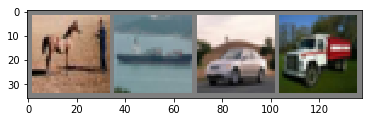

horse  ship   car truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(train_loader) # get some random training images
images, labels = data_iter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 64, 3)
        self.fc1 = nn.Linear(64 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 64 * 2 * 2)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Define a Loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

In [7]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.302
[1,  4000] loss: 2.232
[1,  6000] loss: 1.972
[1,  8000] loss: 1.769
[1, 10000] loss: 1.642
[1, 12000] loss: 1.568
[2,  2000] loss: 1.483
[2,  4000] loss: 1.435
[2,  6000] loss: 1.390
[2,  8000] loss: 1.371
[2, 10000] loss: 1.345
[2, 12000] loss: 1.299
[3,  2000] loss: 1.247
[3,  4000] loss: 1.232
[3,  6000] loss: 1.211
[3,  8000] loss: 1.179
[3, 10000] loss: 1.151
[3, 12000] loss: 1.164
[4,  2000] loss: 1.086
[4,  4000] loss: 1.096
[4,  6000] loss: 1.087
[4,  8000] loss: 1.069
[4, 10000] loss: 1.054
[4, 12000] loss: 1.078
[5,  2000] loss: 0.959
[5,  4000] loss: 0.993
[5,  6000] loss: 0.999
[5,  8000] loss: 0.990
[5, 10000] loss: 0.975
[5, 12000] loss: 0.979
[6,  2000] loss: 0.899
[6,  4000] loss: 0.882
[6,  6000] loss: 0.912
[6,  8000] loss: 0.913
[6, 10000] loss: 0.909
[6, 12000] loss: 0.902
[7,  2000] loss: 0.797
[7,  4000] loss: 0.831
[7,  6000] loss: 0.839
[7,  8000] loss: 0.838
[7, 10000] loss: 0.852
[7, 12000] loss: 0.861
[8,  2000] loss: 0.742
[8,  4000] 

## 5. Test the network on the test data

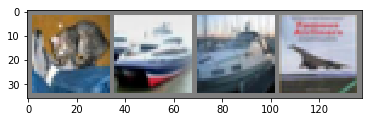

GroundTruth:    cat  ship  ship plane


In [8]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship truck  ship


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the train images: 79 %


In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Test')
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Train')
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Test
Accuracy of plane : 61 %
Accuracy of   car : 79 %
Accuracy of  bird : 49 %
Accuracy of   cat : 46 %
Accuracy of  deer : 62 %
Accuracy of   dog : 53 %
Accuracy of  frog : 75 %
Accuracy of horse : 68 %
Accuracy of  ship : 80 %
Accuracy of truck : 80 %
Train
Accuracy of plane : 75 %
Accuracy of   car : 90 %
Accuracy of  bird : 67 %
Accuracy of   cat : 65 %
Accuracy of  deer : 78 %
Accuracy of   dog : 67 %
Accuracy of  frog : 84 %
Accuracy of horse : 84 %
Accuracy of  ship : 89 %
Accuracy of truck : 90 %
